In [1]:
%%time

import bempp.api
import numpy as np
import time

ta = time.time()

import sys
sys.path.append('../../')
from decimal import *

import bemppUQ
from bemppUQ.operators.maxwell import assemble_operators, evaluate_far_field, evaluate_far_field_sd

bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
bempp.api.global_parameters.hmat.eps = 1E-4


from bemppUQ.shapes import reentrant_cube_exterior

def function(x, y, i, j):
    zx = 0
    zy = 0
    if i == 0:
        zx = np.sin(x * np.pi * 2)
    if i == 1:
        if x <= 0.25:
            zx = np.sin(x * np.pi * 4)
    if i == 2:
        if x > 0.25:
            zx = -np.sin(x * np.pi * 4)
    if i == 3:
        if x <= 0.5 / 3.:
            zx = np.sin(x * np.pi * 6)
    if i == 4:
        if x > 0.5 / 3. and x <= 1 / 3.:
            zx = -np.sin(x * np.pi * 6)
    if i ==5:
        if x > 1/3.:
            zx = np.sin(x * np.pi * 6)

    if j == 0:
        zy = np.sin(y * np.pi * 2)

    if j == 1:
        if y <= 0.25:
            zy = np.sin(y * np.pi * 4)

    if j == 2:
        if y > 0.25:
            zy = -np.sin(y * np.pi * 4)
    
    if j == 3:
        if y <= 0.5 / 3.:
            zy = np.sin(y * np.pi * 6)

    if j == 4:
        if y > 0.5 / 3. and y <= 1 / 3.:
            zy = -np.sin(y * np.pi * 6)
    if j == 5:
        if y > 1/3.:
            zy = np.sin(y * np.pi * 6)

    return zx * zy


# Def random:

def Phiz(point, n, domain_index, result):
    x, y, z = point

    res = 0j
    if z == 0.5 and (x <= 0.5) and (y <= 0.5):
        for ii in range(6):
            for jj in range(6):
                res += Random[ii,jj] * function(x, y, ii,jj)	
    result[0] = res



def perturbate(grid, t, kappa_pert=None):
    P1 = bempp.api.function_space(grid, 'B-P', 1)
    grid_funz = bempp.api.GridFunction(P1, fun = Phiz)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    
    vertices[2, :] = z + t * grid_funz.coefficients
    return bempp.api.grid_from_element_data(vertices, elements)



def get_base_grid(h):

    gr0 = bempp.api.shapes.reentrant_cube(h=h, refinement_factor=1) 
    elements0 = list(gr0.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    tol = h / 10.
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2]) - z) < tol:
            gr0.mark(el0)
    gr1 = gr0.refine()


    elements0 = list(gr1.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2])-z) < tol:
            gr1.mark(el0)

    base_grid = gr1.refine()
    return base_grid

config = bemppUQ.config.set_case('A')

#### define l0 and l1

l0 = 2
l1 = 2

precision_list = [2, 4, 10]

precision0 = precision_list[l0]
precision1 = precision_list[l1]

h0 = 2.0 * np.pi / (precision0 * config["k_int"])
h1 = 2.0 * np.pi / (precision1 * config["k_int"])

# generate the grids

if l0 == 2:
    grid0 = get_base_grid(h=h0) 
else:
    grid0 = bempp.api.shapes.reentrant_cube(h=h0, refinement_factor=1) 

if l1 == 2:
    grid1 = get_base_grid(h=h1)
else:
    grid1 = bempp.api.shapes.reentrant_cube(h=h1, refinement_factor=1) 
    
N0 = 2 * grid0.leaf_view.entity_count(1)
N1 = 2 * grid1.leaf_view.entity_count(1)

print(N0, N1, N0 * N1)

transmission_operators0 = assemble_operators(grid0, config)
transmission_operators1 = assemble_operators(grid1, config)

Umean0, solution0 = evaluate_far_field(transmission_operators0, config)
Umean1, solution1 = evaluate_far_field(transmission_operators1, config)

nrank = 6
grid_funs0 = []
grid_funs1 = []

for ii in range(nrank):
    for jj in range(nrank):
        print(ii,jj)
        def fun(point, n, domain_index, result):
            x, y, z = point

            res = 0j
            if z == 0.5 and (x <= 0.5) and (y <= 0.5):
                res += function(x, y, ii,jj)
            result[0] = res
            
        space0 = bempp.api.function_space(grid0, 'B-P', 1)
        grid_fun0 = bempp.api.GridFunction(space0, fun= fun)
        grid_funs0.append(grid_fun0)
        
        space1 = bempp.api.function_space(grid1, 'B-P', 1)
        grid_fun1 = bempp.api.GridFunction(space1, fun= fun)
        grid_funs1.append(grid_fun1)

        
result0 = evaluate_far_field_sd(grid0, transmission_operators0, config, solution0, grid_funs0, solve = True)
result1 = evaluate_far_field_sd(grid1, transmission_operators1, config, solution1, grid_funs1, solve = True) 

n = config['number_of_angles']





3204 3204 10265616
iteration - 1 || residual - 0.145570369404 0.8572871685028076
iteration - 2 || residual - 0.0303848264104 0.5787692070007324
iteration - 3 || residual - 0.00667101666613 0.744403600692749
iteration - 4 || residual - 0.00108642514403 0.7710311412811279
iteration - 5 || residual - 0.000218854097476 0.7140130996704102
iteration - 6 || residual - 4.56938052444e-05 0.7264325618743896
iteration - 7 || residual - 9.49719737069e-06 0.03172755241394043
iteration - 1 || residual - 0.145570369404 1.071988821029663
iteration - 2 || residual - 0.0303848264104 0.45089149475097656
iteration - 3 || residual - 0.00667101666613 0.4797670841217041
iteration - 4 || residual - 0.00108642514403 0.45514678955078125
iteration - 5 || residual - 0.000218854097476 0.6317360401153564
iteration - 6 || residual - 4.56938052444e-05 0.6257567405700684
iteration - 7 || residual - 9.49719737069e-06 0.05312490463256836
0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2

iteration - 1 || residual - 0.0774748874241 0.8810136318206787
iteration - 2 || residual - 0.00724116324435 0.45943593978881836
iteration - 3 || residual - 0.00082685502561 0.43713855743408203
iteration - 4 || residual - 0.000147858640117 0.4910733699798584
iteration - 5 || residual - 2.7364001108e-05 0.4662187099456787
iteration - 6 || residual - 5.72383447066e-06 0.024871349334716797
19
iteration - 1 || residual - 0.062528334952 0.9135134220123291
iteration - 2 || residual - 0.00671792809793 0.4788241386413574
iteration - 3 || residual - 0.000832429115409 0.4338653087615967
iteration - 4 || residual - 0.000131534372236 0.47612810134887695
iteration - 5 || residual - 2.24003064544e-05 0.45498132705688477
iteration - 6 || residual - 4.67820817635e-06 0.06608915328979492
20
iteration - 1 || residual - 0.0716889697402 0.9973945617675781
iteration - 2 || residual - 0.00716784251027 0.5163784027099609
iteration - 3 || residual - 0.000764963230824 0.5435504913330078
iteration - 4 || residua

iteration - 1 || residual - 0.059122191732 0.9326510429382324
iteration - 2 || residual - 0.00588322543194 0.4644286632537842
iteration - 3 || residual - 0.000780713844715 0.4735441207885742
iteration - 4 || residual - 0.000148153344905 0.47625231742858887
iteration - 5 || residual - 2.85087496754e-05 0.4863548278808594
iteration - 6 || residual - 5.42766340578e-06 0.0023453235626220703
4
iteration - 1 || residual - 0.0611183824267 0.894578218460083
iteration - 2 || residual - 0.00619909087498 0.46306490898132324
iteration - 3 || residual - 0.000825396530362 0.4598958492279053
iteration - 4 || residual - 0.00015225858554 0.45390939712524414
iteration - 5 || residual - 2.80603662702e-05 0.463716983795166
iteration - 6 || residual - 5.85242506614e-06 0.04767036437988281
5
iteration - 1 || residual - 0.0666195740698 0.8766264915466309
iteration - 2 || residual - 0.00686613627086 0.46341753005981445
iteration - 3 || residual - 0.000977508055892 0.45753026008605957
iteration - 4 || residual

iteration - 1 || residual - 0.0647569234836 0.8787250518798828
iteration - 2 || residual - 0.0056366496246 0.475740909576416
iteration - 3 || residual - 0.000725240884819 0.48349905014038086
iteration - 4 || residual - 0.00012507332911 0.5011987686157227
iteration - 5 || residual - 2.16384526794e-05 0.48423147201538086
iteration - 6 || residual - 4.45355993471e-06 0.021621227264404297
25
iteration - 1 || residual - 0.0669121306616 0.9284491539001465
iteration - 2 || residual - 0.00656136441346 0.5796611309051514
iteration - 3 || residual - 0.000697575306375 0.47716331481933594
iteration - 4 || residual - 0.000107224954907 0.48667478561401367
iteration - 5 || residual - 1.90905963329e-05 0.4899260997772217
iteration - 6 || residual - 3.83416329368e-06 0.05553483963012695
26
iteration - 1 || residual - 0.0670225711471 0.9007949829101562
iteration - 2 || residual - 0.00589634917331 0.4515864849090576
iteration - 3 || residual - 0.000631889797836 0.5046024322509766
iteration - 4 || residua

In [9]:
axis = 2
Sigma = np.zeros((n, n), dtype=np.complex128)
k = 0
for ii in range(nrank):
    for jj in range(nrank):
        ff0 = result0[k][axis]
        ff1 = result1[k][axis]
        Sigma += 1/3. * bemppUQ.utils.login.tensorize(ff0,ff1)
        k += 1
        
t = 0.05
Uvars = t ** 2 * Sigma.diagonal()
Umeans = Umean1[axis]

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


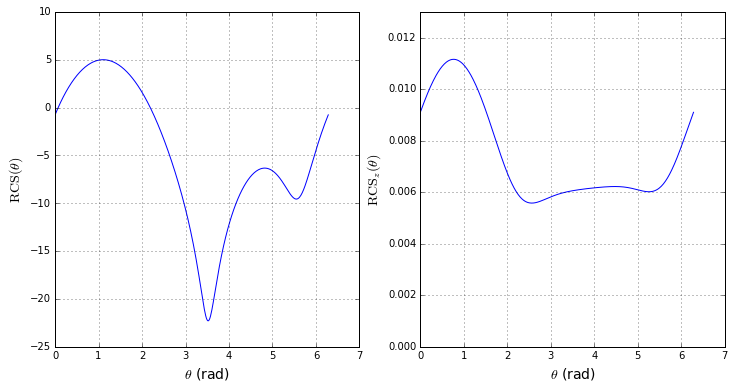

In [13]:
from matplotlib import pyplot as plt

angles = config['angles']

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,6))

cs = 10 * np.log10(4 * np.pi * np.abs(Umeans)**2)

ax1.plot(angles, cs)


y = np.sqrt(np.abs(Uvars))
#y = 10 * np.log10(4 * np.pi * y **2)

ax2.plot(angles, y)


ax2.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax2.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)


ax1.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax1.set_ylabel(r'$\mathrm{RCS}(\theta)$', fontsize=14)

ax1.legend()
ax1.grid()

ax2.legend()
ax2.grid()
ax2.set_ylim(0, 0.013)

plt.savefig('results/LowRank.pdf')
plt.show(block=False)
